In [1]:
from quests_data import *
from einstein import einstein_crystal

import itertools
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from einstein import einstein_crystal

from quests.tools.plotting import savefig
from quests.tools.polyfit import PolynomialRegressor2D, find_zero_points

ROOT_DIR = "../data/A11-Cu"

## Loading the data and constants for the Einstein crystal

In [2]:
fcc = pd.read_csv(f"{ROOT_DIR}/ti/fcc.csv", index_col=0)
bcc = pd.read_csv(f"{ROOT_DIR}/ti/bcc.csv", index_col=0)

spring_k = 34.148
temperature = 3000
mass = 63.546
GPa = 1 / 160.21766208
kB = 1 / 8.617333e-5

In [3]:
VOLS = [65, 70, 75, 80]
TEMPS = np.arange(3000, 5001, 250)

In [4]:
def integr(x, y):
    fn = interp1d(x, y, kind="cubic")
    integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)
    return integ

def integr2(x, y):
    x = np.sqrt(x)
    fn = interp1d(x, 2 * x * y, kind="linear")
    integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)
    return integ

## Get the free energies from thermodynamic integration

In [5]:
results = []
for (v, t) in itertools.product(VOLS, TEMPS):
    _f = fcc.loc[(fcc.folder == v) & (fcc.temperature == t)] 
    _b = bcc.loc[(bcc.folder == v) & (bcc.temperature == t)] 
    f_ein, u_ein, s_ein = einstein_crystal(spring_k=spring_k, temperature=t, mass=mass)
    
    f_fcc = integr2(_f["lambda"], -_f["energy"] + u_ein)
    f_bcc = integr2(_b["lambda"], -_b["energy"] + u_ein)
    
    results.append({
        "T": t,
        "V": v / 10,
        "U_fcc": _f["energy"].iloc[0],
        "U_bcc": _b["energy"].iloc[0],
        "F_ein": f_ein,
        "S_ein": kB * s_ein,
        "U_ein": u_ein,
        "F_fcc": -f_fcc + f_ein,
        "F_bcc": -f_bcc + f_ein,
        "P_fcc": _f["pressure"].iloc[0],
        "P_bcc": _b["pressure"].iloc[0],
    })
    
df = pd.DataFrame(results)

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_45919/1650940517.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)


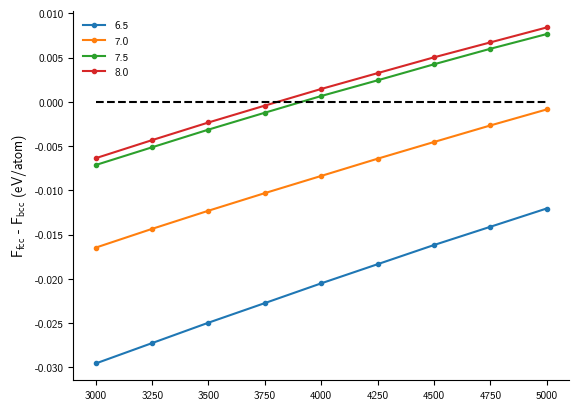

In [6]:
fig, ax = plt.subplots()

for v, grp in df.groupby("V"):
    ax.plot(grp["T"], grp["F_fcc"] - grp["F_bcc"], "o-", markersize=3, label=v)
    
ax.plot([3000, 5000], [0.0, 0.0], "k--")

# ax.set_ylim(-0.02, 0.02)
ax.set_ylabel("F$_{fcc}$ - F$_{bcc}$ (eV/atom)")
ax.legend(frameon=False)

# savefig(fig, "02-Cu-dF.pdf")
plt.show()

In [7]:
sdf = []
for v, grp in df.groupby("V"):
    _t = grp["T"].iloc[1:]
    _dt = grp["T"].diff().iloc[1:]
    _sf = -grp["F_fcc"].diff().iloc[1:] / _dt * kB
    _sb = -grp["F_bcc"].diff().iloc[1:] / _dt * kB
    
    for i, temp in enumerate(_t):
        sdf.append({
            "T": _t.iloc[i],
            "V": v,
            "S_fcc": _sf.iloc[i],
            "S_bcc": _sb.iloc[i],
            "dS": _sf.iloc[i] - _sb.iloc[i],
        })
        
sdf = pd.DataFrame(sdf)

In [8]:
df["G_fcc"] = df["F_fcc"] + df["P_fcc"] * df["V"] * GPa
df["G_bcc"] = df["F_bcc"] + df["P_bcc"] * df["V"] * GPa
df["dG"] = df["G_fcc"] - df["G_bcc"]

## Comparing against the DFT data

In [9]:
smirnov = pd.read_csv(f"{ROOT_DIR}/SmirnovCu.csv")
smirnov["T"] = smirnov["T"] * 1000
smirnov = smirnov.loc[
    (smirnov["P"] >= 179) &
    (smirnov["P"] <= 280) &
    (smirnov["T"] >= 3600) &
    (smirnov["T"] <= 4800) 
]

In [10]:
deg = 2
kwargs = {"alpha": 0.0001, "max_iter": 1000000}

smirnov_fn = PolynomialRegressor2D(deg, smirnov[["P"]].values, smirnov["T"].values, **kwargs)
v_fcc_fn = PolynomialRegressor2D(deg, df[["P_fcc", "T"]].values, df["V"].values, **kwargs)
v_bcc_fn = PolynomialRegressor2D(deg, df[["P_bcc", "T"]].values, df["V"].values, **kwargs)
f_fcc_fn = PolynomialRegressor2D(deg, df[["V", "T"]].values, df["F_fcc"].values, **kwargs)
f_bcc_fn = PolynomialRegressor2D(deg, df[["V", "T"]].values, df["F_bcc"].values, **kwargs)

In [11]:
num_t = 500
num_p = 500

ts = np.linspace(3600, 4800, num_t)
ps = np.linspace(180, 280, num_p)

gts, gps = np.meshgrid(ts, ps)
nts = gts.ravel()
nps = gps.ravel()

In [12]:
smirnov_p = np.unique(nps)
smirnov_t = smirnov_fn(smirnov_p.reshape(-1, 1))
idx = smirnov_t <= 4800
smirnov_p = smirnov_p[idx]
smirnov_t = smirnov_t[idx]

## Free energy transformations to get the phase diagram

In [13]:
npts = np.stack([nps, nts]).T

vs_fcc = v_fcc_fn(npts)
vs_bcc = v_bcc_fn(npts)

fs_fcc = f_fcc_fn(np.stack([vs_fcc, nts]).T)
fs_bcc = f_bcc_fn(np.stack([vs_bcc, nts]).T)

gs_fcc = fs_fcc + vs_fcc * nps * GPa
gs_bcc = fs_bcc + vs_bcc * nps * GPa

dgs = gs_fcc - gs_bcc

gs = dgs.reshape(gts.shape)

In [14]:
ti_p, ti_t = find_zero_points(gps, gts, gs, tol=1e-5)

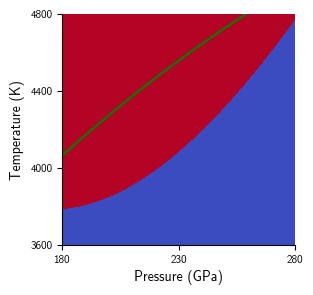

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

norm = plt.Normalize(-1e-5, 1e-5)
cf = ax.contourf(gps, gts, gs, cmap="coolwarm", norm=norm)

# ax.scatter(smirnov["P"], smirnov["T"])
ax.plot(smirnov_p, smirnov_t, "g-")

ax.set_xlabel("Pressure (GPa)")
ax.set_ylabel("Temperature (K)")

ax.set_xticks([180, 230, 280])
ax.set_yticks([3600, 4000, 4400, 4800])
ax.set_xlim([180, 280])

# savefig(fig, "02-Cu-PT.pdf")
plt.show()

### Now, we load the entropies calculated with QUESTS

In [16]:
hf = pd.read_csv(f"{ROOT_DIR}/entropy/fcc.csv", index_col=0).set_index(["temperature", "press"])
hb = pd.read_csv(f"{ROOT_DIR}/entropy/bcc.csv", index_col=0).set_index(["temperature", "press"])
dH = hb["entropy"] - hf["entropy"]
dU = hb["energy"] - hf["energy"]
dV = hb["volume"] - hf["volume"]
tp = np.array(hf.index.tolist())

In [17]:
deg = 2
kwargs = {"alpha": 0.0001, "max_iter": 1000000}

v_fcc_fn = PolynomialRegressor2D(deg, tp, hf["volume"].values, **kwargs)
v_bcc_fn = PolynomialRegressor2D(deg, tp, hb["volume"].values, **kwargs)
u_fcc_fn = PolynomialRegressor2D(deg, tp, hf["energy"].values, **kwargs)
u_bcc_fn = PolynomialRegressor2D(deg, tp, hb["energy"].values, **kwargs)
h_fcc_fn = PolynomialRegressor2D(deg, tp, hf["entropy"].values, **kwargs)
h_bcc_fn = PolynomialRegressor2D(deg, tp, hb["entropy"].values, **kwargs)

In [18]:
ntps = np.stack([nts, nps], axis=1)

In [19]:
dv = v_bcc_fn(ntps) - v_fcc_fn(ntps)
du = u_bcc_fn(ntps) - u_fcc_fn(ntps)
dh = h_bcc_fn(ntps) - h_fcc_fn(ntps)

In [20]:
dG = du - (1 / kB) * dh * nts + nps * dv * GPa
dGgrid = dG.reshape(gts.shape)

In [21]:
ours_p, ours_t = find_zero_points(gps, gts, dGgrid, tol=1e-5)

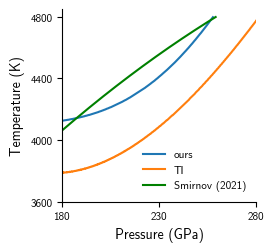

In [22]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.plot(ours_p, ours_t, label="ours")
ax.plot(ti_p, ti_t, label="TI")
ax.plot(smirnov_p, smirnov_t, "g-", label="Smirnov (2021)")

ax.set_xlabel("Pressure (GPa)")
ax.set_ylabel("Temperature (K)")

ax.set_xticks([180, 230, 280])
ax.set_yticks([3600, 4000, 4400, 4800])
ax.set_xlim([180, 280])

ax.legend(frameon=False)

# savefig(fig, "02-Cu-PT.pdf")
plt.show()